In [1]:
import pandas as pd

df = pd.read_csv('LC_loans_granting_model_dataset.csv', low_memory=False)

In [2]:
df.head()

,id,issue_d,revenue,dti_n,loan_amnt,fico_n,experience_c,emp_length,purpose,home_ownership_n,addr_state,zip_code,Default,title,desc
0,68407277,Dec-2015,55000.0,5.91,3600,677.0,1,10+ years,debt_consolidation,MORTGAGE,PA,190xx,0,Debt consolidation,NaN
1,68355089,Dec-2015,65000.0,16.06,24700,717.0,1,10+ years,small_business,MORTGAGE,SD,577xx,0,Business,NaN
2,68341763,Dec-2015,71000.0,13.85,20000,697.0,1,10+ years,home_improvement,MORTGAGE,IL,605xx,0,NaN,NaN
3,68476807,Dec-2015,104433.0,25.37,10400,697.0,1,3 years,major_purchase,MORTGAGE,PA,174xx,0,Major purchase,NaN
4,68426831,Dec-2015,34000.0,10.20,11950,692.0,1,4 years,debt_consolidation,RENT,GA,300xx,0,Debt consolidation,NaN


In [3]:
df.shape

(1347681, 15)

In [4]:
df.size

20215215

In [5]:
df.dtypes

id                    int64
issue_d              object
revenue             float64
dti_n               float64
loan_amnt             int64
fico_n              float64
experience_c          int64
emp_length           object
purpose              object
home_ownership_n     object
addr_state           object
zip_code             object
Default               int64
title                object
desc                 object
dtype: object

In [6]:
df.describe()

,id,revenue,dti_n,loan_amnt,fico_n,experience_c,Default
count,1.347681e+06,1.347681e+06,1.347681e+06,1.347681e+06,1.347681e+06,1.347681e+06,1.347681e+06
mean,5.621359e+07,7.736968e+04,1.829909e+01,1.440823e+04,6.981589e+02,9.999814e-01,1.997869e-01
std,3.839501e+07,7.036299e+04,1.115214e+01,8.715347e+03,3.184872e+01,4.306977e-03,3.998402e-01
min,5.473400e+04,1.896000e+03,0.000000e+00,5.000000e+02,6.120000e+02,0.000000e+00,0.000000e+00
25%,1.970651e+07,4.660000e+04,1.182000e+01,7.975000e+03,6.720000e+02,1.000000e+00,0.000000e+00
50%,5.766422e+07,6.500000e+04,1.763000e+01,1.200000e+04,6.920000e+02,1.000000e+00,0.000000e+00
75%,8.449505e+07,9.200000e+04,2.407000e+01,2.000000e+04,7.120000e+02,1.000000e+00,0.000000e+00
max,1.456364e+08,1.099920e+07,9.990000e+02,4.000000e+04,8.475000e+02,1.000000e+00,1.000000e+00


In [7]:
print("Checking Missing Values:")
print(df.isnull().sum())

Checking Missing Values:
id                        0
issue_d                   0
revenue                   0
dti_n                     0
loan_amnt                 0
fico_n                    0
experience_c              0
emp_length                0
purpose                   0
home_ownership_n          0
addr_state                0
zip_code                  1
Default                   0
title                 16657
desc                1228582
dtype: int64


In [8]:
df = df.drop(['zip_code', 'desc', 'title'], axis=1, errors='ignore')


In [9]:
df = df.dropna(thresh=len(df)*0.7, axis=1) # Drop columns with too many missing values

numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

In [10]:
# Encoding categorical columns with low cardinality (less than 20 unique values)
low_cardinality = [col for col in categorical_cols if df[col].nunique() < 20]
df = pd.get_dummies(df, columns=low_cardinality, drop_first=True)

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder() #lable encoding for remaining object columns
for col in df.select_dtypes(include='object').columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

In [14]:
from sklearn.model_selection import train_test_split

X = df.drop('Default', axis=1)
y = df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

C:\Users\ihase\anaconda3\envs\summarizer\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [17]:
import lightgbm as lgb
from sklearn.metrics import classification_report

lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_resampled, y_resampled)
y_pred_lgbm = lgbm.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 862554, number of negative: 862554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.197619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 1725108, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_test, y_pred_lgbm))
print("Recall:", recall_score(y_test, y_pred_lgbm))
print("F1 Score:", f1_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))

Precision: 0.46011222249329103
Recall: 0.035147878268324044
F1 Score: 0.06530697046296617
              precision    recall  f1-score   support

           0       0.80      0.99      0.89    215878
           1       0.46      0.04      0.07     53659

    accuracy                           0.80    269537
   macro avg       0.63      0.51      0.48    269537
weighted avg       0.74      0.80      0.72    269537



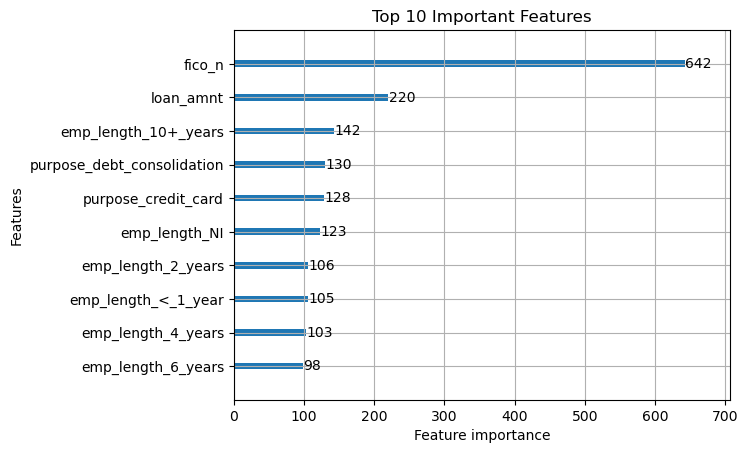

In [24]:
import matplotlib.pyplot as plt

lgb.plot_importance(lgbm, max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()